# Wild Tree and loss
> A tree loss for classifiying categories as a tree structure

In [2]:
# default_exp wildtree

In [3]:
# export
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
from typing import Callable, List, Dict

## Sample data

We down load the data from [oncotree here](http://oncotree.mskcc.org/api/tumorTypes/tree?&version=oncotree_latest_stable), save as json file

In [4]:
import os
import json

In [5]:
with open(Path(os.environ['HOME'])/"Downloads"/"oncotree.json","r") as f:
    oncotree = json.load(f)

In [60]:
oncotree['TISSUE'].keys()

dict_keys(['code', 'color', 'name', 'mainType', 'externalReferences', 'tissue', 'children', 'parent', 'history', 'level', 'revocations', 'precursors'])

## Wildtree

In [7]:
# export
def cache(f: Callable) -> Callable:
    """
    cache for class property, use as decorator
    """
    fname = f.__name__

    def wrapper(self):
        if fname in self.caches:
            return self.caches[fname]
        else:
            v = f(self)
            self.caches[fname] = v
            return v
    return wrapper
        
class WildNode:
    """
    A node in graph, with uncertain edge possibilities
    """
    def __init__(self, name):
        self.name = name
        self.nodes[name] = self
        self.as_parent = []
        self.as_kid = []
        self.all_edges = []
        self.caches = dict()

    @classmethod
    def get(cls, name):
        if name in cls.nodes:
            return cls.nodes[name]
        else:
            return cls(name)

    def __repr__(self) -> str:
        return self.name

    @property
    @cache
    def kids(self):
        return list(e.kid for e in self.as_parent)

    @property
    @cache
    def parents(self):
        return list(e.parent for e in self.as_kid)

    @property
    @cache
    def kid_summary(self):
        return dict(Counter(map(lambda x: x.name, self.kids)))

    @property
    @cache
    def parent_summary(self):
        return dict(Counter(map(lambda x: x.name, self.parents)))

    @property
    @cache
    def detail(self) -> str:
        return f"<name:{self.name},level:{self.to_root}>\n\tparents:{self.parent_summary}\n\tkids:{self.kid_summary}"
    
    @classmethod
    def calc_to_root(cls, root):
        for node in cls.nodes.values():
            path = node.search(root)
            node.to_root = len(path)-1

    def search(self, another: str) -> List[Dict[str, str]]:
        """
        Search a treval parth within a possible tree
        - another: str, name
        """
        fresh_step = {"name": self.name, "direction": "none", "freq":"1"}
        searched = dict({self.name: {"path": [fresh_step]}})
        unsearched = self.nodes.keys()
        height = []
        latest_depth = [self.name, ]

        def conclude(
            latest_depth: List[Dict[str, str]],
            new_depth: List[Dict[str, str]]
        ):
            latest_depth.clear()
            latest_depth += new_depth

        def deeper():
            new_depth = []
            for name in latest_depth:

                obj = self.get(name)
                for direction, summary in\
                    zip(
                        ["up", "down"],
                        [obj.parent_summary, obj.kid_summary]):
                    for n, freq in summary.items():
                        if n in searched:
                            continue

                        new_step = {"name": n, "freq": freq,
                                    "direction": direction}
                        searched[n] = dict(
                            path=searched[name]["path"]+[new_step, ])
                        new_depth.append(n)
                        conclude(latest_depth, new_depth)
                        if another == n:
                            return
            conclude(latest_depth, new_depth)

        while True:
            if len(latest_depth) == 0:
                return []
            if another in latest_depth:
                return searched[another]['path']

            deeper()

class WildEdge:
    def __init__(
        self,
        parent: WildNode,
        kid: WildNode,
    ):
        self.parent = parent
        self.kid = kid
        for node in [parent, kid]:
            node.all_edges.append(self)
        parent.as_parent.append(self)
        kid.as_kid.append(self)
        self.edges.append(self)

    def __repr__(self):
        return f"[parent:{self.parent}][kid:{self.kid}]"
    
class WildTree:
    """
    A tree that will analyze a tree structure
        from (parent-kid) pairs data
        use tree.create_new_edge('parent','kid') to 
            add a new edge
            
    The tree doesn't have to be a very clear structure,
        2 nodes can have both parent-kid and siblings relationship
        the tree will find the shortest path anyway
        
    ### **Important**
    After added all the edges**, use ```tree.root_map``` for
        finding the tree root.
    
    tree('name1','name2') to get a dataframe on travel path
    """
    def __init__(self):
        self.node_class,self.edge_class = self.new_class()
        self.create_new_edge=self.edge_class.from_names
        self.nodes = self.node_class.nodes
        
    def find_a_root(self):
        for k, node in self.nodes.items():
            if len(node.parents)==0 and len(node.kids)!=0:
                yield node
        
    def __repr__(self):
        return f"tree.node_class,tree.create_new_edge('a', 'b')"
    
    def __getitem__(self, node_name:str):
        return self.nodes[node_name]
    
    def new_class(self):
        class TreeNode(WildNode):
            nodes = dict()
        class TreeEdge(WildEdge):
            nodes = TreeNode.nodes
            edges = list()
            @classmethod
            def from_names(cls, parent: str, kid: str,):
                return cls(
                    TreeNode.get(parent),
                    TreeNode.get(kid))
        
        TreeEdge.nodes = TreeNode.nodes
        return TreeNode,TreeEdge
    
    def root_map(self):
        """
        Necessary step!
        Run this after input all the edges
        """
        self.root = next(self.find_a_root())
        self.node_class.calc_to_root(self.root.name)
        
    def __call__(self, a: str, b: str) -> pd.DataFrame:
        """
        Calculate the travel path between 2 nodes
        """
        df = pd.DataFrame(self[a].search(b))
        df['to_root'] = df.name.apply(lambda x:self[x].to_root)
        return df

## Test wildtree

In [8]:
def parse_node(node: WildNode, callback: Callable) -> None:
    parent = node['name']
    if 'children' in node:
        for child_name,child_node in node['children'].items():
            # this is the onlything you have to do to fill a 
            # wild tree data, create new edge for 
            # every parent/kid string pairs
            callback(parent, child_node['name'])
            parse_node(child_node, callback=callback)

In [9]:
tree = WildTree()

In [10]:
parse_node(oncotree['TISSUE'], callback=tree.create_new_edge)

In [11]:
tree.root_map()

WildTree found the root node automatically

In [13]:
tree.root

Tissue

In [59]:
print('\t'.join(list(tree.nodes.keys())[:100]))

Tissue	Ovary/Fallopian Tube	Ovarian Cancer, Other	Ovarian Choriocarcinoma, NOS	High-Grade Neuroendocrine Carcinoma of the Ovary	High-Grade Serous Fallopian Tube Cancer	Ovarian Epithelial Tumor	Endometrioid Borderlin Ovarian Tumor	Serous Ovarian Cancer	High-Grade Serous Ovarian Cancer	Low-Grade Serous Ovarian Cancer	Brenner Tumor	Brenner Tumor, Benign	Brenner Tumor, Borderline	Brenner Tumor, Malignant	Clear Cell Borderline Ovarian Tumor	Ovarian Seromucinous Carcinoma	Ovarian Seromucinous Adenoma	Endometrioid Ovarian Cancer	Serous Borderline Ovarian Tumor	Mucinous Ovarian Cancer	Serous Borderline Ovarian Tumor, Micropapillary	Mixed Ovarian Carcinoma	Mucinous Borderline Ovarian Tumor	Clear Cell Ovarian Cancer	Small Cell Carcinoma of the Ovary	Ovarian Seromucinous Borderline Tumor	Ovarian Carcinosarcoma/Malignant Mixed Mesodermal Tumor	Ovarian Germ Cell Tumor	Immature Teratoma	Polyembryoma	Mixed Germ Cell Tumor	Mature Teratoma	Dysgerminoma	Embryonal Carcinoma	Yolk Sac Tumor	Sex Cord Stroma

In [15]:
tree('Chromophobe Renal Cell Carcinoma','Pleomorphic Adenoma')

,name,direction,freq,to_root
0,Chromophobe Renal Cell Carcinoma,none,1,4
1,Renal Non-Clear Cell Carcinoma,up,1,3
2,Renal Cell Carcinoma,up,1,2
3,Kidney,up,1,1
4,Tissue,up,1,0
5,Head and Neck,down,1,1
6,Salivary Carcinoma,down,1,2
7,Pleomorphic Adenoma,down,1,3


In [17]:
print(tree['Chromophobe Renal Cell Carcinoma'].detail)

<name:Chromophobe Renal Cell Carcinoma,level:4>
	parents:{'Renal Non-Clear Cell Carcinoma': 1}
	kids:{}


## Integrate to binary cross entropy
This part will create loss function with weights (according to tree), nhot encoder to translate string of a branch

In [24]:
# export
def calc_weight(x: np.array):
    """
    Calculate the weight for BCELoss,
        where the nodes closer to root will cause bigger loss
        when it's wronged confidently
    """
    exp = np.exp(-x)
    return exp/exp.sum()

def loss_package(tree: WildTree) -> dict:
    """
    Create an entire package of things,
    Input:
    - tree: WildTree
    Output:
    - dictionary keys:
        - weight
        - bce_loss: a pytorch nn module
        - encoder: Callable, a function translate name to nhot encoding
        - name_list: a list of entity names
        - to_root_list: an numpy array describe the
            travel distance to root
    - 
    """
    import torch
    from torch import nn
    to_root_df = pd.DataFrame(
        list(dict(name=name, to_root=node.to_root)
             for name,node in tree.nodes.items()))
    
    to_root_df = to_root_df\
        .sort_values(by="to_root",ascending=True,)\
        .reset_index(drop=True)
    
    name_list = list(to_root_df.name)
    n2i = dict((v,k) for k,v in enumerate(name_list))
    to_root_list = np.array(list(to_root_df.to_root))
    
    weight = torch.FloatTensor(calc_weight(to_root_list)*100)
    bce_loss = nn.BCELoss(weight=weight)
    
    eye = np.eye(len(name_list))
    
    def encoder(
        branch: str
    ) -> np.array:
        """
        An encoder translate name to nhot encoding
            which we can use as Y label
        """
        node = tree[branch]
        idx = np.array(
            list(map(lambda x: n2i[x['name']],
                     node.search(tree.root.name))),dtype=int)
        return eye[idx].sum(axis=0)
    
    return dict(weight=weight,
                bce_loss=bce_loss,
                name_list=name_list,
                encoder=encoder,
                to_root_list=to_root_list)

In [25]:
package = loss_package(tree)

### Encoder function

In [28]:
from matplotlib import pyplot as plt

In [40]:
encoder = package['encoder']

In [43]:
encoder('Renal Non-Clear Cell Carcinoma')[:200]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Visualize a port of nhot encoding

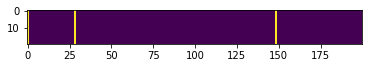

In [46]:
plt.imshow(encoder('Renal Non-Clear Cell Carcinoma')[None,:200].repeat(20,axis=0))

### A list of int suggest the travel distance to root of all the categories

In [55]:
package['to_root_list']

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

### Loss function

In [49]:
bce_loss = package["bce_loss"]
type(bce_loss)

torch.nn.modules.loss.BCELoss

The loss function as weights according to the structure

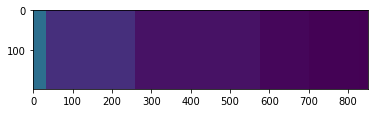

In [54]:
plt.imshow(bce_loss.weight.numpy()[None,].repeat(200,axis=0))